# Выбор локации для скважины

Добывающей компании нужно решить, где бурить новую скважину.

Были предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 

Задача: построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль; проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<a class="anchor"  id="0"><a/>
**Содержание**

- [1  Загрузка и подготовка данных](#1)
- [2  Обучение и проверка модели](#2)
- [3  Подготовка к расчёту прибыли](#3)
- [4  Расчёт прибыли и рисков](#4)
- [5 Общий вывод](#5)

## Загрузка и подготовка данных
<a id="1"><a/>

In [1]:
# Блок с импортом библиотек.
!pip install phik -q
import phik
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

In [2]:
# Зададим константы.
# Общий бюджет на разработку.
BUDGET = 10000000000

# Число исследуемых при разведке территории точек.
EXPLORE_POINTS = 500

# Число точек выбираемых к разработке по итогам машинного обучения.
BEST_POINTS = 200

# Цена за баррель в рублях.
BARREL_PRICE = 450

RANDOM_STATE = 4221

Передадим данные следующим переменным:

- **geo_data_first**: данные о первом регионе.
- **geo_data_second**: данные о втором регионе.
- **geo_data_third**: данные о третьем регионе.

In [3]:
geo_data_first = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_second = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_third = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# Функция для обзора исходных данных.
def df_informer(df):
    print('Первые 20 строк таблицы: \n')
    display(df.head(20))
    print('Общая информация о данных: \n')
    display(df.info())
    print('Количество явных дубликатов: ', df.duplicated().sum())
    print('Сводная статистика по данным: \n')
    display(df.describe().T)

**geo_data_first:**

In [5]:
df_informer(geo_data_first)

Первые 20 строк таблицы: 



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


**geo_data_second:**

In [6]:
df_informer(geo_data_second)

Первые 20 строк таблицы: 



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


**geo_data_third:**

In [7]:
df_informer(geo_data_third)

Первые 20 строк таблицы: 



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Общая информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество явных дубликатов:  0
Сводная статистика по данным: 



,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


**Отметим следующее:**

- В данных нет пропусков, типы данных соответствуют наблюдаемым значениям, явных дубликатов не обнаружено.
- Имеются нулевые значения среди объёмов запасов. Это немного странно с учётом того, что запасы вычисляются с точностью до тысячной доли барреля. 

Может быть, мы заметим взаимосвязь нулевого значения запасов с входными признаками.

In [8]:
# Выведем строки с нулевым значением объёма.
geo_data_first[geo_data_first['product'] == 0].head(20)

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


In [9]:
geo_data_second[geo_data_second['product'] == 0].head(20)

,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893512,-0.001601,0.0
81,gdvra,-3.246882,-7.979657,0.009027,0.0
82,VHp5v,15.363643,-6.456659,0.004302,0.0
83,dm9rM,13.494965,-0.543358,0.001352,0.0
127,6az0U,13.951600,-5.077510,-0.005232,0.0
128,iDXiz,6.820803,5.220184,-0.007179,0.0


In [10]:
geo_data_third[geo_data_third['product'] == 0].head(20)

,id,f0,f1,f2,product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


Выделяющихся отличий от остальных данных не видим. Похоже, данные либо пропущены, либо выставлены вручную по итогу исследования территории.

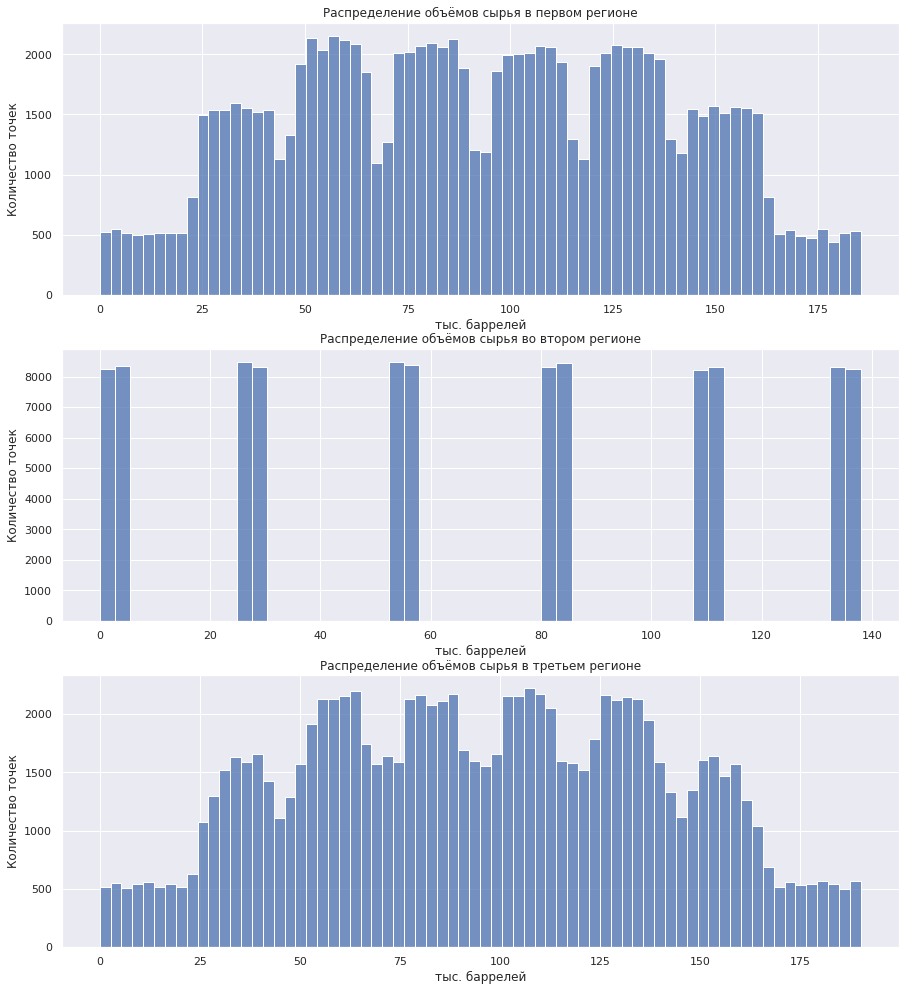

In [11]:
sns.set(rc={'figure.figsize': (15, 17)})
fig, axs = plt.subplots(3, 1)
    
sns.histplot(data=geo_data_first, bins=70, x='product', ax=axs[0])
axs[0].set(ylabel='Количество точек', xlabel='тыс. баррелей', title='Распределение объёмов сырья в первом регионе')
    
sns.histplot(data=geo_data_second, bins=50, x='product', ax=axs[1])
axs[1].set(ylabel='Количество точек', xlabel='тыс. баррелей', title='Распределение объёмов сырья во втором регионе')

sns.histplot(data=geo_data_third, bins=70, x='product', ax=axs[2])
axs[2].set(ylabel='Количество точек', xlabel='тыс. баррелей', title='Распределение объёмов сырья в третьем регионе');

Распределения в первом и третьем регионах очень похожи. Во втором регионе, судя по всему, не так много уникальных значений. Интересно, как это получилось. Могут ли несколько точек относться к одному месторождению? Или, может, значения во втором регионе были вычислены отличительно от остальных. Ну, как бы то не было, характер линейной связи входных с целевым должен быть сходным. Взглянем на корреляцию.

In [12]:
# Функция для отображения матрицы корреляции.
def phik_matrix_creator(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.drop('id', axis=1).phik_matrix(
    interval_cols=[
        'f0', 
        'f1', 
        'f2',
        'product'
    ]
), annot=True, cmap='coolwarm', fmt='.2f')

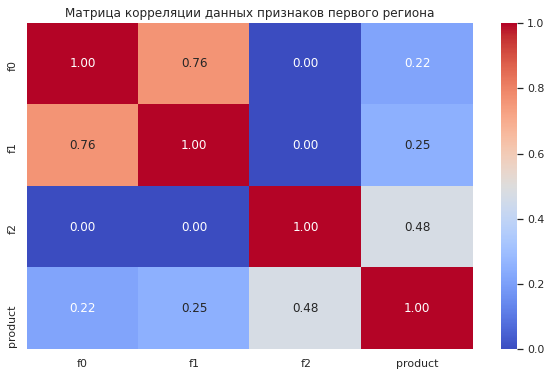

In [13]:
phik_matrix_creator(geo_data_first)
plt.title('Матрица корреляции данных признаков первого региона');

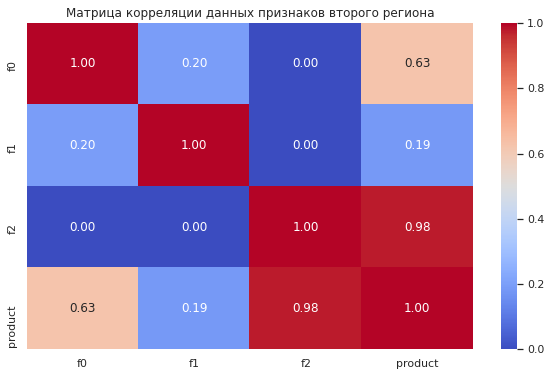

In [14]:
phik_matrix_creator(geo_data_second)
plt.title('Матрица корреляции данных признаков второго региона');

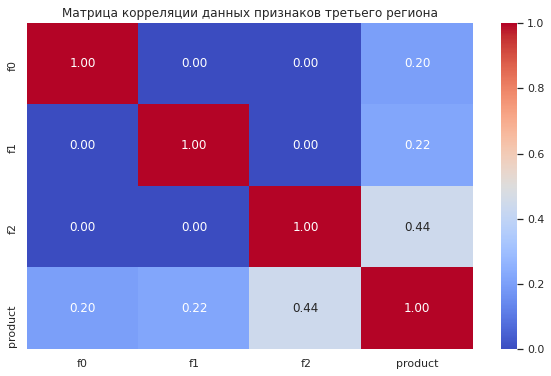

In [15]:
phik_matrix_creator(geo_data_third)
plt.title('Матрица корреляции данных признаков третьего региона');

Признак f2 сильнее других коррелирует с целевым. Для второго региона его уровень корреляции вообще настолько большой, что можно заподозрить утечку данных по признаку.

**Итоги обзора и подготовки данных:**

- Исходные таблицы с данными содержат по 100000 строк и 5 признаков.
- При исследовании были обнаружены нулевые значения в целевом признаке. По общему характеру данных предположено, что значения либо пропущены, либо указаны вручную. 
- Отметим, что данные первого и третьего регионов имеют схожее распределение значений целевого признака, и также сходную корреляцию входных признаков с целевым. Данные целевого признака во втором регионе имеют не так много уникальных значений, очевидно они были заполнены как-то отличительно от значений остальных регионов. Теснота связи входных признаков **f0** и **f2** с целевым во втором регионе значительно более сильная. В целом, в целевом признаке второго региона упущено много информации; сложно сказать, что результатам будущей модели можно будет доверять.

[Назад к содержанию](#0)

## Обучение и проверка модели
<a id="2"><a/>

Входные признаки имеют примерно сходный масштаб, возможно масштабировать их дополнительно будет излишне. Из интереса взглянем на метрики по обоим решениям.

In [16]:
# Функция для разделения выборок.
def spliter(df):
    X = df.drop('product', axis=1)
    y = df['product']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    
    return X_train, X_test, y_train, y_test

In [17]:
# Функция для разделения выборок  масштабированием входных признаков.
def scaled_spliter(df, num):
    X_train, X_test, y_train, y_test = spliter(df.set_index('id'))
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num])
    X_test_scaled = scaler.transform(X_test[num])
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = scaled_spliter(geo_data_first, ['f0', 'f1', 'f2'])

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

RMSE: 37.79536808017317


In [19]:
X_train, X_test, y_train, y_test = spliter(geo_data_first.set_index('id'))

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
#print('Cредний запас предсказанного сырья в первом регионе:', y_pred.mean())

RMSE: 37.79536808017317


Разницы нет, масштабировать входные признаки не будем. 

In [20]:
# Функция для обучения моделей и вывода результатов.
def linear_maker(df, region):
    X_train, X_test, y_train, y_test = spliter(df.set_index('id'))

    model = LinearRegression()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Cохраним валидационную выборку с предсказанными значениями.
    valid_df = pd.concat([X_test, y_test], axis=1)
    valid_df['product_pred'] = y_pred
    
    print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
    print(f'Cредний запас предсказанного сырья {region} регионе:', y_pred.mean())
    print(f'Cредний запас фактического сырья {region} регионе:', y_test.mean())
    
    return valid_df

In [21]:
valid_df_first = linear_maker(geo_data_first, 'в первом')
valid_df_first.head()

RMSE: 37.79536808017317
Cредний запас предсказанного сырья в первом регионе: 92.5746130469428
Cредний запас фактического сырья в первом регионе: 92.69844267462285


,f0,f1,f2,product,product_pred
id,,,,,
Wg6fJ,-0.515530,0.849147,4.533501,131.440709,93.773800
5oxLt,0.206677,-0.453100,1.826458,173.289721,96.558535
VR4VW,0.481424,-0.244048,2.903650,48.572970,101.851927
G4dsI,1.683845,0.119734,2.843392,166.719256,101.034262
xVlIu,0.615263,0.548230,0.234765,60.745583,73.807126


In [23]:
valid_df_second = linear_maker(geo_data_second, 'во втором')
valid_df_second.head()

RMSE: 0.8904248837272424
Cредний запас предсказанного сырья во втором регионе: 68.79990326767886
Cредний запас фактического сырья во втором регионе: 68.80402898069894


,f0,f1,f2,product,product_pred
id,,,,,
JFMwt,0.636038,-6.154061,4.002144,110.992147,109.558556
eGpsK,14.269190,-4.784171,4.000396,107.813044,107.502802
IlL9o,-9.065402,0.497919,3.991703,110.992147,110.543704
1zV74,-4.666205,-7.723681,2.002307,57.085625,56.463173
cWTNu,-15.339543,-1.925930,4.002067,110.992147,111.785706


In [24]:
valid_df_third = linear_maker(geo_data_third, 'в третьем')
valid_df_third.head()

RMSE: 40.09419604130936
Cредний запас предсказанного сырья в третьем регионе: 95.2360595056648
Cредний запас фактического сырья в третьем регионе: 94.56052356036137


,f0,f1,f2,product,product_pred
id,,,,,
eF98g,-0.709867,0.306790,2.757401,157.823991,96.661827
9EY4b,-1.674663,-1.294556,-0.515639,64.789552,78.024214
R5zvz,-0.271799,-1.294793,1.360498,33.157327,88.781774
t8nxU,0.426891,4.354175,-0.014983,110.737272,80.280117
yUc7j,-0.083019,1.896165,0.633381,111.295064,84.270789


**Итоги обучения моделей:**

Для создания предсказаний объёмов залежей нефти создали модели линейной регрессии ез масштабирования входных признаков.

Результаты по данным первого региона:

- RMSE: 37.79536808017317
- Cредний запас предсказанного сырья в первом регионе: 92.5746130469428
- Cредний запас фактического сырья в первом регионе: 92.69844267462285

Результаты по данным второго региона:

- RMSE: 0.8904248837272424
- Cредний запас предсказанного сырья во втором регионе: 68.79990326767886
- Cредний запас фактического сырья во втором регионе: 68.80402898069894

Результаты по данным третьего региона:

- RMSE: 40.09419604130936
- Cредний запас предсказанного сырья в третьем регионе: 95.2360595056648
- Cредний запас фактического сырья в третьем регионе: 94.56052356036137

Лучший результат показала модель на данных второго региона, но как мы уже отметили прежде, результаты её предсказаний вызывают определённые сомнения.

[Назад к содержанию](#0)

## Подготовка к расчёту прибыли
<a id="3"><a/>

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [28]:
# Средняя достаточная прибыль за одну точку.
sufficient_profit_one_point = BUDGET / BEST_POINTS
print('Средняя достаточная прибыль за одну точку:', sufficient_profit_one_point, 'рублей')

sufficient_volume_one_point = sufficient_profit_one_point / BARREL_PRICE / 1000
print('Средний достаточный объём нефти на точку:', sufficient_volume_one_point, 'тыс. баррелей')

sufficient_volume_region = sufficient_volume_one_point * BEST_POINTS 
print('Достаточный объём нефти на регион:', sufficient_volume_region, 'тыс. баррелей')

Средняя достаточная прибыль за одну точку: 50000000.0 рублей
Средний достаточный объём нефти на точку: 111.11111111111111 тыс. баррелей
Достаточный объём нефти на регион: 22222.222222222223 тыс. баррелей


In [29]:
# Выведем среднее значение фактических запасов на одну точку в каждом регионе.
print('Средний запас фактичекой нефти на скважину в первом регионе:', geo_data_first['product'].mean())
print('Средний запас фактичекой нефти на скважину во втором регионе:', geo_data_second['product'].mean())
print('Средний запас фактичекой нефти на скважину в третьем регионе:', geo_data_third['product'].mean())

Средний запас фактичекой нефти на скважину в первом регионе: 92.50000000000001
Средний запас фактичекой нефти на скважину во втором регионе: 68.82500000000002
Средний запас фактичекой нефти на скважину в третьем регионе: 95.00000000000004


In [30]:
# Соберём функцию для рассчёта прибыли по выбранным скважинам и предсказаниям модели.
def profit_maker(target, probs, count, barrel_price, budget):
    best_points = probs.sort_values(ascending=False).head(BEST_POINTS)
    selected = target[best_points.index][:count]
    profit = selected.sum() * barrel_price * 1000 - budget
    return profit

**Итоги подготовки:**

- Ввели ключевые значения.


- Вычислили значения необходимые для безубыточной разработки новой скважины:
  - Средняя достаточная прибыль за одну точку: 50000000.0 рублей
  - Средний достаточный объём нефти на точку: 111.11111111111111 тыс. баррелей
  - Достаточный объём нефти на регион: 22222.222222222223 тыс. баррелей
  
  
- Вывели среднее значение фактических запасов на одну точку в каждом регионе:
  - Средний запас фактичекой нефти на скважину в первом регионе: 92.50000000000001
  - Средний запас фактичекой нефти на скважину во втором регионе: 68.82500000000002
  - Средний запас фактичекой нефти на скважину в третьем регионе: 95.00000000000004
  
  
- Создали функцию для подсчёта прибыли.

[Назад к содержанию](#0)

## Расчёт прибыли и рисков 
<a id="4"><a/>

In [31]:
# Создадим функцию для процедуры Bootstrap.
def bootstrap(target, region):
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        subsample_target = target.sample(n=EXPLORE_POINTS, replace=True, random_state=state)
        subsample_probs = subsample_target['product_pred']
        profit = profit_maker(subsample_target['product'], subsample_probs, BEST_POINTS, BARREL_PRICE, BUDGET)
        values.append(profit)
        
    values = pd.Series(values)
    mean_profit = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print(f'Расчёт прибыли и рисков для {region}:')
    print('Средняя прибыль:', mean_profit / 1000000, 'млн. руб')
    print('Нижняя граница довертиельного интервала:', lower / 1000000, 'млн. руб')
    print('Верхняя граница довертиельного интервала:', upper/ 1000000, 'млн. руб')
    print(f'Риск убытка: {(values < 0).mean():.2%}')
    print('__________________')

In [32]:
bootstrap(valid_df_first, 'первого региона')
bootstrap(valid_df_second, 'второго региона')
bootstrap(valid_df_third, 'третьего региона')

Расчёт прибыли и рисков для первого региона:
Средняя прибыль: 488.25851236541774 млн. руб
Нижняя граница довертиельного интервала: -59.161870861014066 млн. руб
Верхняя граница довертиельного интервала: 1014.007318253325 млн. руб
Риск убытка: 4.50%
__________________
Расчёт прибыли и рисков для второго региона:
Средняя прибыль: 493.92990456115047 млн. руб
Нижняя граница довертиельного интервала: 85.31108627614073 млн. руб
Верхняя граница довертиельного интервала: 894.4889306664539 млн. руб
Риск убытка: 0.90%
__________________
Расчёт прибыли и рисков для третьего региона:
Средняя прибыль: 317.79495697097417 млн. руб
Нижняя граница довертиельного интервала: -291.54659431413 млн. руб
Верхняя граница довертиельного интервала: 874.1201647317188 млн. руб
Риск убытка: 12.50%
__________________


[Назад к содержанию](#0)

## Общий вывод
<a id="5"><a/>

Добывающей компанией «ГлавРосГосНефть» поставлена задача решить, где бурить новую скважину. Для решения данной задачи проделаны проделаны следующие шаги:

**1 Загрузка и подготовка данных**:

- Исходные таблицы с данными содержат по 100000 строк и 5 признаков.
- При исследовании были обнаружены нулевые значения в целевом признаке. По общему характеру данных предположено, что значения либо пропущены, либо указаны вручную. 
- Отметили, что данные первого и третьего регионов имеют схожее распределение значений целевого признака, и также сходную корреляцию входных признаков с целевым. Данные целевого признака во втором регионе имеют не так много уникальных значений, очевидно они были заполнены как-то отличительно от значений остальных регионов. Теснота связи входных признаков **f0** и **f2** с целевым во втором регионе значительно более сильная. В целом, в целевом признаке второго региона упущено много информации; сложно сказать, что результатам будущей модели можно будет доверять.

**2 Обучение и проверка модели**:

Для создания предсказаний объёмов залежей нефти создали модели линейной регрессии ез масштабирования входных признаков.

Результаты по данным первого региона:

- RMSE: 37.79536808017317
- Cредний запас предсказанного сырья в первом регионе: 92.5746130469428
- Cредний запас фактического сырья в первом регионе: 92.69844267462285

Результаты по данным второго региона:

- RMSE: 0.8904248837272424
- Cредний запас предсказанного сырья во втором регионе: 68.79990326767886
- Cредний запас фактического сырья во втором регионе: 68.80402898069894

Результаты по данным третьего региона:

- RMSE: 40.09419604130936
- Cредний запас предсказанного сырья в третьем регионе: 95.2360595056648
- Cредний запас фактического сырья в третьем регионе: 94.56052356036137

Лучший результат показала модель на данных второго региона, но как мы уже отметили прежде, результаты её предсказаний вызывают определённые сомнения.

**3 Подготовка к расчёту прибыли**:

- Ввели ключевые значения.


- Вычислили значения необходимые для безубыточной разработки новой скважины:
  - Средняя достаточная прибыль за одну точку: 50000000.0 рублей
  - Средний достаточный объём нефти на точку: 111.11111111111111 тыс. баррелей
  - Достаточный объём нефти на регион: 22222.222222222223 тыс. баррелей
  
  
- Вывели среднее значение фактических запасов на одну точку в каждом регионе:
  - Средний запас фактичекой нефти на скважину в первом регионе: 92.50000000000001
  - Средний запас фактичекой нефти на скважину во втором регионе: 68.82500000000002
  - Средний запас фактичекой нефти на скважину в третьем регионе: 95.00000000000004
  
  
- Создали функцию для подсчёта прибыли.

**4 Расчёт прибыли и рисков**:


<font color='green'>
    
    
Расчёт прибыли и рисков для первого региона:
- Средняя прибыль: 488.25851236541774 млн. руб
- Нижняя граница довертиельного интервала: -59.161870861014066 млн. руб
- Верхняя граница довертиельного интервала: 1014.007318253325 млн. руб
- Риск убытка: 4.50%
    
__________________
    
Расчёт прибыли и рисков для второго региона:
- Средняя прибыль: 493.92990456115047 млн. руб
- Нижняя граница довертиельного интервала: 85.31108627614073 млн. руб
- Верхняя граница довертиельного интервала: 894.4889306664539 млн. руб
- Риск убытка: 0.90%
__________________
    
Расчёт прибыли и рисков для третьего региона:
- Средняя прибыль: 317.79495697097417 млн. руб
- Нижняя граница довертиельного интервала: -291.54659431413 млн. руб
- Верхняя граница довертиельного интервала: 874.1201647317188 млн. руб
- Риск убытка: 12.50%</font>

<font color='green'>
При условии, что исходные данные второго региона верно отражают реальное распределение запасов, регион показывает самое высокое значение средней прибыли (493.929 млн рублей), а также самый низкий риск убытков (0.9%).</font>